<img align="left" src="img/ECE364-logo.png" width="300px" style="padding:30px;border:thin solid white;"> 

# Lecture 7 - Linear Regression I
## ECE364 - Programming Methods for Machine Learning
### Nickvash Kani 












###### Slides based off prior lectures by Alex Schwing, Aigou Han, Farzad Kamalabadi, Corey Snyder. All mistakes are my own!

Things we'll cover in today's lecture: 

- Linear regression intro
- Least squares loss function
- Matrix solution for linear models

## Linear regression - main idea

Let's say we have the following graph: 

<img align="middle" src="img/scatter_plot_data_only.png" width="500px" style="padding:30px;border:thin solid white;"> 

Given outcomes (targets) $y^{(i)} \in \mathbb{R}$ for covariates (inputs) $x^{(i)} \in \mathbb{R}$, what is/are the underlying system model and/or the parameters. 

Multiple possible solutions to the data: 

<img align="middle" src="img/scatter_plot_with_sample_lines.png" width="500px" style="padding:30px;border:thin solid white;"> 

Visually, the best fit is obvious. But how do we communicate the best fit to a computer?


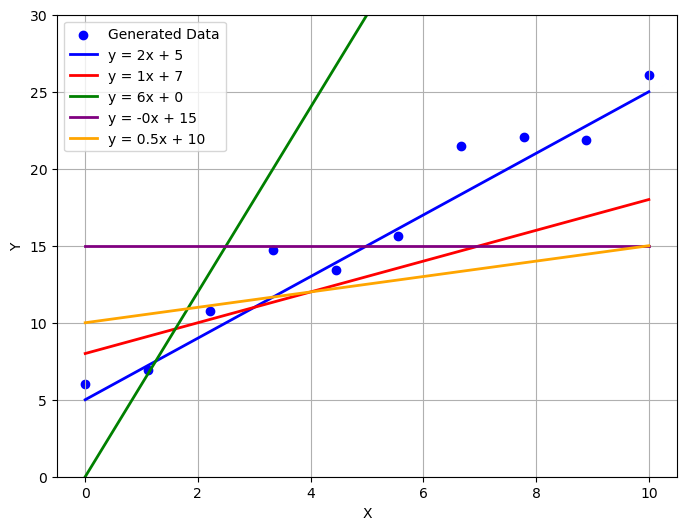

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate 10 x values between 0 and 10
x = np.linspace(0, 10, 10)

# Generate y values with some variability around the line y = 2x + 5
y = 2 * x + 5 + np.random.normal(0, 2, size=len(x))

# Create the figure and axis
plt.figure(figsize=(8, 6))

# Scatter plot of generated points
plt.scatter(x, y, label='Generated Data', color='blue')

# Plot the line y = 2x + 5
plt.plot(x, 2 * x + 5, label='y = 2x + 5', color='blue', linewidth=2)
plt.plot(x, 1 * x + 8, label='y = 1x + 7', color='red', linewidth=2)
plt.plot(x, 6 * x + 0, label='y = 6x + 0', color='green', linewidth=2)
plt.plot(x, 0 * x + 15, label='y = -0x + 15', color='purple', linewidth=2)
plt.plot(x, 0.5 * x + 10, label='y = 0.5x + 10', color='orange', linewidth=2)

# Labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(0, 30)
#plt.title('Scatter Plot with Best Fit Line (Seed = 42)')
plt.legend()
plt.grid(True)

#plt.show()

# Save the plot to a file
plt.savefig("./img/scatter_plot_with_sample_lines.png", dpi=300, bbox_inches='tight')

# Close the plot to avoid displaying it
#plt.close()

Let's assume the best model is linear: 

$$ y = wx + b $$

where $y$ is the prediction, $w$ is the weight(s), and $b$ is the bias

$w$ and $b$ are the parameters. 

How do we measure how far (or close) one set of parameters is to the data? 

## Database notation

Quick note about notation for data: 

- Given a dataset ${\cal D} = \{(x^{(i)},y^{(i)})\}_{i=1}^N$
- Data $x^{(i)} \in \mathbb{R}^d$
- **Question:** Given new unseen data $𝑥$ how to predict its label $𝑦$?

## Loss function - least squares

The first error we'll discuss is the **squared error** loss: 

$$ \mathcal{L}(y,t) = \frac{1}{2}\left( y-t \right)^2 $$ 

- $y-t$ is called the residual (see below) and we want to make it as small as possible
- $y$ is the predicted value and $t$ is the ground truth
- the $\frac{1}{2}$ factor is just to make our gradient calculation cleaner later, it doesn't really affect anything

<img align="middle" src="img/scatter_plot_with_residuals.png" width="500px" style="padding:30px;border:thin solid white;"> 






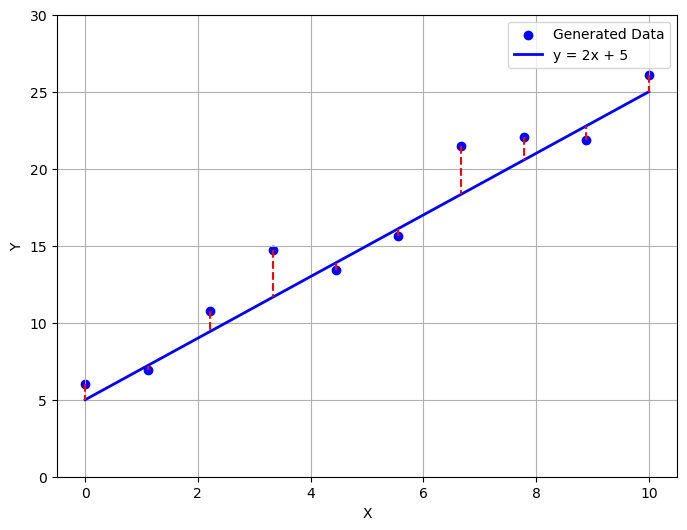

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate 10 x values between 0 and 10
x = np.linspace(0, 10, 10)

# Generate y values with some variability around the line y = 2x + 5
y = 2 * x + 5 + np.random.normal(0, 2, size=len(x))

# Create the figure and axis
plt.figure(figsize=(8, 6))

# Scatter plot of generated points
plt.scatter(x, y, label='Generated Data', color='blue')

# Plot the line y = 2x + 5
plt.plot(x, 2 * x + 5, label='y = 2x + 5', color='blue', linewidth=2)

for xi, yi in zip(x, y):
    plt.plot([xi, xi], [yi, 2 * xi + 5], color='red', linestyle='dashed')

# Labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(0, 30)
#plt.title('Scatter Plot with Best Fit Line (Seed = 42)')
plt.legend()
plt.grid(True)

# plt.show()

# Save the plot to a file
plt.savefig("./img/scatter_plot_with_residuals.png", dpi=300, bbox_inches='tight')

# Close the plot to avoid displaying it
#plt.close()

**Loss function**: loss function averaged over all training examples

$$
\mathcal{E}(w, b) = \frac{1}{2N} \sum_{i=1}^{N} \left( y^{(i)} - t^{(i)} \right)^2
$$

$$
= \frac{1}{2N} \sum_{i=1}^{N} \left( wx^{(i)} + b - t^{(i)} \right)^2
$$

Depending on the value of $w$/$b$ we choose, the loss can differ significantly: 

<img align="left" src="img/scatter_plot_with_sample_lines.png" width="450px" style="padding:30px;border:thin solid white;"> <img align="right" src="img/loss_contour_with_guesses.png" width="450px" style="padding:30px;border:thin solid white;"> 



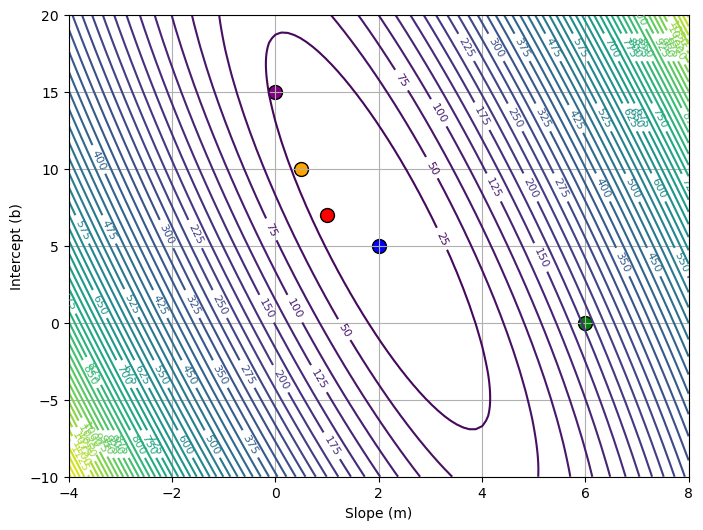

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate 10 x values between 0 and 10
x = np.linspace(0, 10, 10)

# Generate true target values with some noise
true_m = 2
true_b = 5
t = true_m * x + true_b + np.random.normal(0, 2, size=len(x))

# Define ranges for m and b
m_values = np.linspace(-4, 8, 100)
b_values = np.linspace(-10, 20, 100)

# Create a meshgrid for contour plot
M, B = np.meshgrid(m_values, b_values)

# Compute loss for each combination of m and b
loss = np.zeros_like(M)

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        y_pred = M[i, j] * x + B[i, j]
        loss[i, j] = 0.5 * np.mean((y_pred - t) ** 2)

# Create contour plot
plt.figure(figsize=(8, 6))
contour = plt.contour(M, B, loss, levels=50, cmap='viridis')
plt.clabel(contour, inline=True, fontsize=8)
plt.xlabel("Slope (m)")
plt.ylabel("Intercept (b)")
#plt.title("Contour Plot of Loss Function")
plt.grid(True)

# Add specific points with given colors
points = [(2, 5, 'blue'), (1, 7, 'red'), (6, 0, 'green'), (0, 15, 'purple'), (0.5, 10, 'orange')]
for m, b, color in points:
    plt.scatter(m, b, color=color, edgecolors='black', s=100, label=f'({m},{b})')

# Save the plot to a file
plt.savefig("./img/loss_contour_with_guesses.png", dpi=300, bbox_inches='tight')

# Show the plot
#plt.show()


## Solving the optimization problem

So we have the loss function (assuming $y = w_1 x_1 + w_2 x_2 + \ldots + b$

\begin{align}
\mathcal{E}(w_1, \dots, w_D, b) &= \frac{1}{N} \sum_{i=1}^{N} L(y^{(i)}, t^{(i)})\\
                                &= \frac{1}{2N} \sum_{i=1}^{N} \left( y^{(i)} - t^{(i)} \right)^2\\
                                &= \frac{1}{2N} \sum_{i=1}^{N} \left( \sum_{j} w_j x_j^{(i)} + b - t^{(i)} \right)^2 \\
                                &= \frac{1}{2N} \sum_{i=1}^{N} \left(  w x^{(i)} + b - t^{(i)} \right)^2 \text{for 1D linear regression}
\end{align}
Now we need the partial derivatives $\left(\frac{\partial \mathcal{E}}{\partial w}\right)$ and $\left(\frac{\partial \mathcal{E}}{\partial b}\right)$ to solve for the parameters $w$ and $b$

### Direct Solution

---
Let's first simplify the linear equation: 

Instead of $y=wx+b$, let's say $y=w_1x_1 + w_0x_0$ where $x_1$ is the original data point and $x_0=1$ always. Doing things this way allows us to write: $y=WX$ where $W = \left[b, w\right]$ and $X = \left[1, x_1\right]$

---

Writing hings this way helps us simplify our equation:

\begin{align}
\mathcal{E}(w_1, \dots, w_D, b) &= \frac{1}{N} \sum_{i=1}^{N} L(y^{(i)}, t^{(i)})\\
                                &= \frac{1}{2N} \sum_{i=1}^{N} \left( y^{(i)} - t^{(i)} \right)^2\\
                                &= \frac{1}{2N} \sum_{i=1}^{N} \left( \sum_{j} w_j x_j^{(i)} - t^{(i)} \right)^2
\end{align}

--- 

So the partial derivatives of this equation will be: 

$$
\frac{\partial \mathcal{E}}{\partial w_j} = \frac{1}{N} \sum_{i=1}^{N} x_j^{(i)} \left( y^{(i)} - t^{(i)} \right)
$$


So we have:

So the partial derivatives of these equations will be: 

$$
\frac{\partial \mathcal{E}}{\partial w_j} = \frac{1}{N} \sum_{i=1}^{N} x_j^{(i)} \left( y^{(i)} - t^{(i)} \right)
$$

which when we expand it out will be: 

$$
\frac{\partial \mathcal{E}}{\partial w_j} = \frac{1}{N} \sum_{i=1}^{N} x_j^{(i)} \left( \sum_{j'=1}^{D} w_{j'} x_{j'}^{(i)} - t^{(i)} \right)
$$

Notice that if we want to solve for $w$ we need to set the partial derivative to zero. Doing that and with a bit of reorganization we can get: 
 
$$
\frac{\partial \mathcal{E}}{\partial w_j} = \frac{1}{N} \sum_{j'=1}^{D} \left( \sum_{i=1}^{N} x_j^{(i)} x_{j'}^{(i)} \right) w_{j'} - \frac{1}{N} \sum_{i=1}^{N} x_j^{(i)} t^{(i)} = 0
$$


### Gradient Descent

How would we solve this using gradient descent? 


Same way we always calculate things with gradient descent: 

$$
\mathbf{w} \leftarrow \mathbf{w} - \alpha \frac{\partial \mathcal{E}}{\partial \mathbf{w}},
$$

which in our case becomes: 

$$
w_{j+1} \leftarrow w_j - \alpha \frac{1}{N} \sum_{i=1}^{N} x_j \left( y^{(i)} - t^{(i)} \right)
$$

let's test it out!


/var/folders/r5/0w7y2nzn6z519vv67rcw3ffr0000gn/T/ipykernel_69055/1708185210.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(true_m * x + true_b + np.random.normal(0, 2, size=len(x)))


Initial guesses: w0=0.768029, w1=-0.771771
Final guesses: w0=3.829832, w1=2.290032


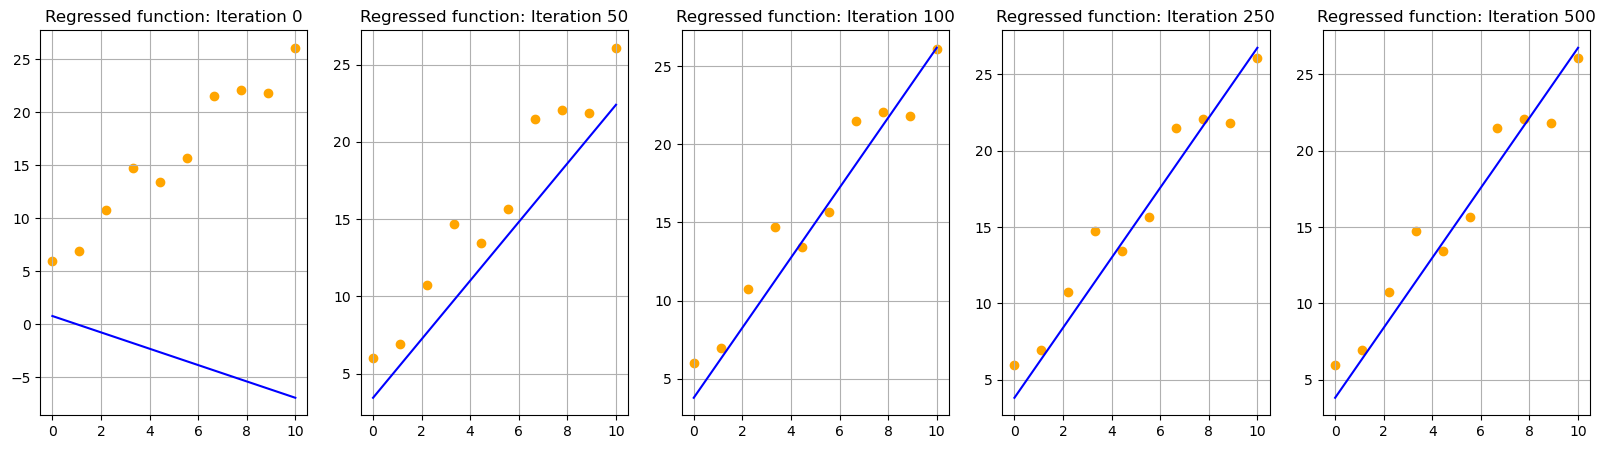

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# dataset we are artificially creating: 
# Set seed for reproducibility
np.random.seed(42)

# Generate 10 x values between 0 and 10
N=10
x = torch.linspace(0, 10, N)

# Generate true target values with some noise
true_m = 2
true_b = 5
t = torch.tensor(true_m * x + true_b + np.random.normal(0, 2, size=len(x)))

X = np.column_stack((np.ones(10), x))

# initialize guesses for w, b
w_gd = torch.randn((2), requires_grad=True) # size (1,)
print('Initial guesses: w0={:.6f}, w1={:.6f}'.format(w_gd[0].data, w_gd[1].data))

# information for tracking
b_vals = [w_gd[0].data.item()]
w_vals = [w_gd[1].data.item()]

# gradient descent loop
n_iter = 100000 # number of iterations
alpha = 1e-3 # step size
for n in range(n_iter):
    with torch.no_grad():
        # don't want the gradient update step to accumulate further gradients at a, b, and c
        y = w_gd[1]*x+w_gd[0]
        w_gd -= alpha*(1/N)*sum(x*(y-t))
        # manually zero out the gradients before next backward pass
        w_gd.grad = None
        
    # log information
    w_vals.append(w_gd[1].data.item())
    b_vals.append(w_gd[0].data.item())
    
# examine solution
print('Final guesses: w0={:.6f}, w1={:.6f}'.format(w_gd[0].data, w_gd[1].data))

iter_num = np.array([0, 50, 100, 250, 500]).astype(int)
plt.figure(figsize=(20, 5))
for j, i in enumerate(iter_num):
    plt.subplot(1, 5, j+1)
    curr_fn = w_vals[i]*x + b_vals[i]
    plt.plot(x.detach().numpy(), curr_fn.detach().numpy(), color='blue')
    plt.scatter(x.detach().numpy(), t, color='orange')
    plt.grid(True)
    plt.title('Regressed function: Iteration {}'.format(i))

Speaking of numerial simulations, do we really need to even calculate the gradient? 

/var/folders/r5/0w7y2nzn6z519vv67rcw3ffr0000gn/T/ipykernel_69055/3946572062.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(true_m * x + true_b + np.random.normal(0, 2, size=len(x)))


Initial guesses: w0=-0.890225, w1=0.122299
Final guesses: w0=5.583348, w1=2.041284


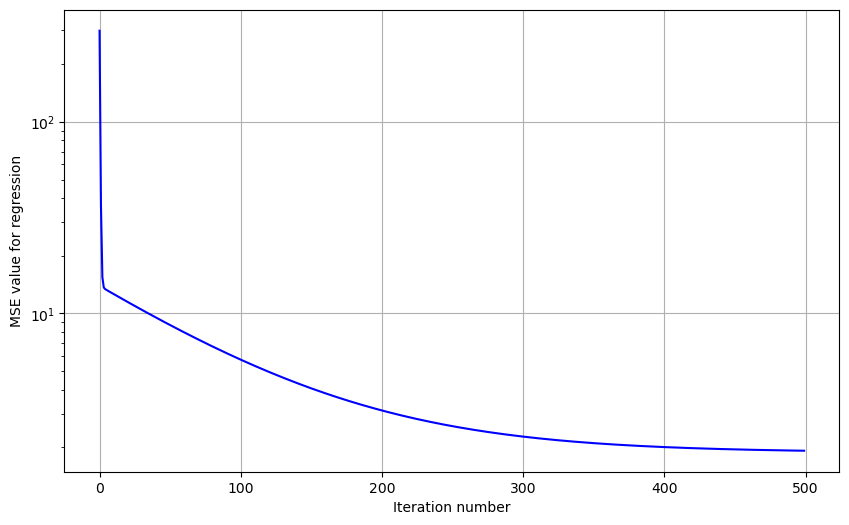

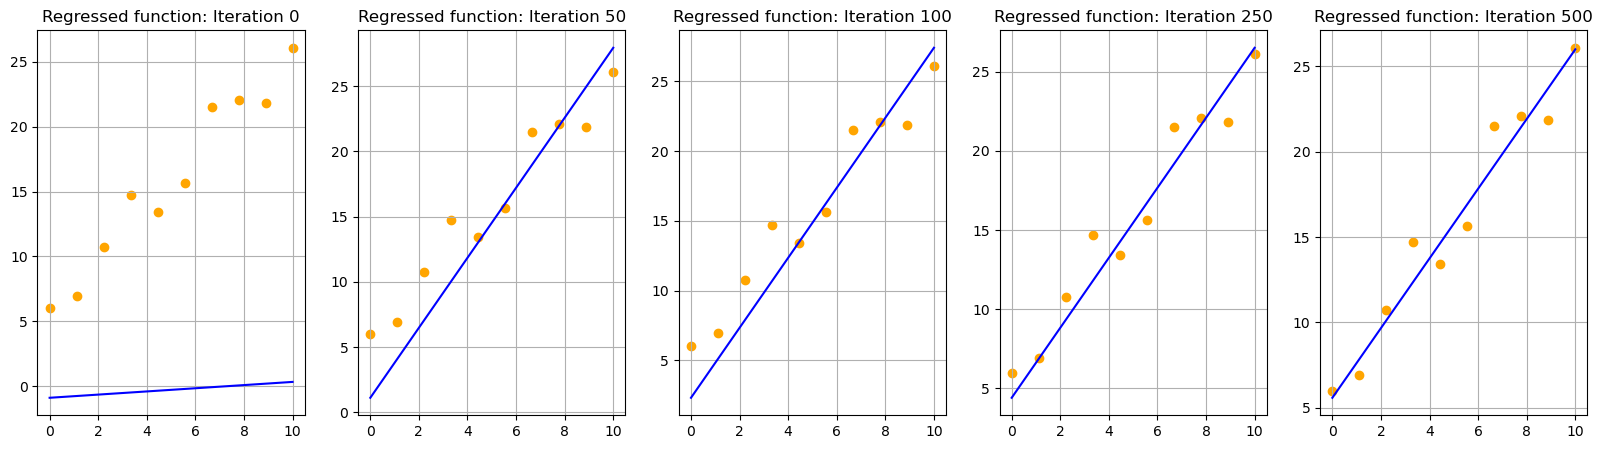

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# dataset we are artificially creating: 
# Set seed for reproducibility
np.random.seed(42)

# Generate 10 x values between 0 and 10
N=10
x = torch.linspace(0, 10, N)

# Generate true target values with some noise
true_m = 2
true_b = 5
t = torch.tensor(true_m * x + true_b + np.random.normal(0, 2, size=len(x)))

X = np.column_stack((np.ones(10), x))

# initialize guesses for m,b
w_gd = torch.randn((2), requires_grad=True) # size (1,)
print('Initial guesses: w0={:.6f}, w1={:.6f}'.format(w_gd[0].data, w_gd[1].data))

# information for tracking
b_vals = [w_gd[0].data.item()]
w_vals = [w_gd[1].data.item()]
loss_vals = []

# gradient descent loop
n_iter = 500 # number of iterations
alpha = 10e-3 # step size
for n in range(n_iter):
    # compute loss function (objective function)
    errors = t-(w_gd[0] + w_gd[1]*x)
    loss = torch.sum((errors)**2)/N
    # backpropagate gradients
    loss.backward()
    # perform gradient descent update step
    with torch.no_grad():
        # don't want the gradient update step to accumulate further gradients at a, b, and c
        w_gd -= alpha*w_gd.grad
        # manually zero out the gradients before next backward pass
        w_gd.grad = None
        
    # log information
    loss_vals.append(loss.item()) # log MSE
    w_vals.append(w_gd[1].data.item())
    b_vals.append(w_gd[0].data.item())
    
# examine solution
print('Final guesses: w0={:.6f}, w1={:.6f}'.format(w_gd[0].data, w_gd[1].data))

# visualize loss and progression of solution
plt.figure(figsize=(10, 6))
plt.semilogy(loss_vals, color='blue')
plt.grid(True)
plt.xlabel('Iteration number')
plt.ylabel('MSE value for regression')

iter_num = np.array([0, 50, 100, 250, 500]).astype(int)
plt.figure(figsize=(20, 5))
for j, i in enumerate(iter_num):
    plt.subplot(1, 5, j+1)
    curr_fn = w_vals[i]*x + b_vals[i]
    plt.plot(x.detach().numpy(), curr_fn.detach().numpy(), color='blue')
    plt.scatter(x.detach().numpy(), t, color='orange')
    plt.grid(True)
    plt.title('Regressed function: Iteration {}'.format(i))

### Matrix Solution

---
Let's revisit this equation: 

$$
\frac{\partial \mathcal{E}}{\partial w_j} = \frac{1}{N} \sum_{j'=1}^{D} \left( \sum_{i=1}^{N} x_j^{(i)} x_{j'}^{(i)} \right) w_{j'} - \frac{1}{N} \sum_{i=1}^{N} x_j^{(i)} t^{(i)} = 0
$$

--- 

We can transform this equation into the vector form: 

$$
X^T X W - X^T T = 0
$$

hence

$$
X^T X W = X^T T 
$$

Then we multiply both sides by $(X^T X)^{-1}$ to get: 

$$
W = (X^T X)^{-1} X^T T 
$$


In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate 10 x values between 0 and 10
x = np.linspace(0, 10, 10)

# Generate true target values with some noise
true_m = 2
true_b = 5
t = true_m * x + true_b + np.random.normal(0, 2, size=len(x))
#t = true_m * x + true_b
#t = np.array([5.99342831,  6.94569362, 10.73982152, 14.71272638, 13.42058214, 15.6428372, 21.49175896, 22.09042501, 21.83882901, 26.08512009])

#print(x)
#print(t)
X = np.column_stack((np.ones(10), x))

W = np.linalg.inv(X.transpose()@X)@X.transpose()@t

print(W)

[5.95822557 1.98757933]


If we had the matrix solution, why would you even bother with gradient descent? 

Linear regression seems pretty great. Why would we bother with anything else? 

Linear regression has its limits: 

<img align="center" src="./img/scatter_plot_with_sample_linear_fail.png" width="500px" style="padding:30px;border:thin solid white;"> 

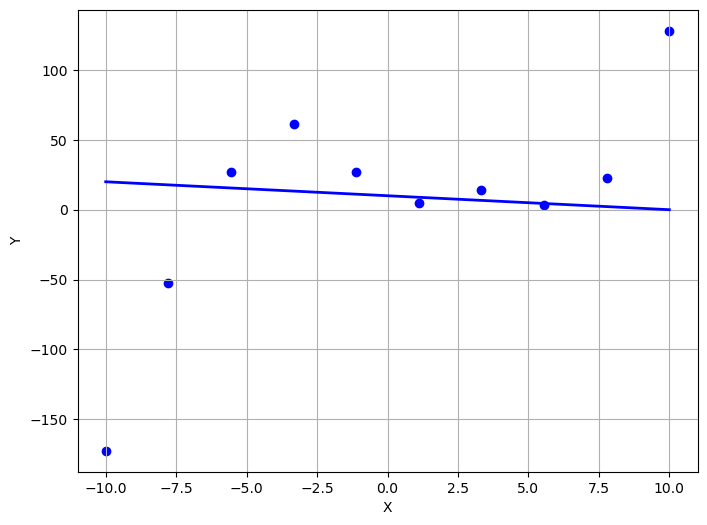

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate 10 x values between 0 and 10
x = np.linspace(-10, 10, 10)

# Generate y values with some variability
def f(x): 
    return 0.25 * x **3 + -0.5 * x**2 + -10 * x + 20 

y = f(x) + np.random.normal(0, 15, size=len(x))


# Create the figure and axis
plt.figure(figsize=(8, 6))

# Scatter plot of generated points
plt.scatter(x, y, label='Generated Data', color='blue')

# Plot the line
px = np.linspace(-10, 10, 100)
plt.plot(px,-1*px+10, label='y = 2x + 5', color='blue', linewidth=2)

# Labels and title
plt.xlabel('X')
plt.ylabel('Y')
#plt.ylim(0, 30)
#plt.title('Scatter Plot with Best Fit Line (Seed = 42)')
#plt.legend()
plt.grid(True)

#plt.show()

# Save the plot to a file
plt.savefig("./img/scatter_plot_with_sample_linear_fail.png", dpi=300, bbox_inches='tight')

## That's it for today

- Have a good weekend!
- Don't forget HW3 is due Monday.

## Additional References

[1] Roger Grosse CSC321 lectures - https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/